In [1]:
import numpy as np
import sklearn

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import copy
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.semi_supervised import SelfTrainingClassifier, LabelPropagation, LabelSpreading

#import mvlearn
#from mvlearn.semi_supervised import CTClassifier

In [2]:
from scipy.stats import multivariate_normal

In [3]:
from numpy.random import multivariate_normal as mvn

In [4]:
"""## Score Metrics - Accuracy, F1 score and Confusion Matrix"""

# Function to calculate the required score metrics
def score_metrics(actual_labels,predicted_labels, show = True):
  
  #Accuracy
    sys_accuracy = accuracy_score(actual_labels,predicted_labels)

  #F1 score
    sys_f1_score = f1_score(actual_labels,predicted_labels, average='micro')
    
  #Confusion Matrix
    sys_cf = confusion_matrix(actual_labels,predicted_labels)
    
    if(show):
        print("Accuracy of system is ", sys_accuracy)
        print("F1 score of system is ", sys_f1_score)
        print("Confusion Matrix of system is \n", sys_cf)
        sns.heatmap(sys_cf,annot = True)
        
    return sys_accuracy

In [5]:
# load the data
df = pd.read_csv("bank-additional-full.csv",
                 delimiter=";", dtype=str)

In [6]:
# data cleaning
df['y'].replace(['yes', 'no'],[0, 1], inplace=True)
df['age'] = pd.to_numeric(df['age'])
df['job'].replace(['admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown'],[1,2,3,4,5,6,7,8,9,10,11,12], inplace = True)
df['marital'].replace(['divorced','married','single','unknown'],[1,2,3,4],inplace = True)
df['education'].replace(['basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown'],[1,2,3,4,5,6,7,8],inplace = True)
df['default'].replace(['no','yes','unknown'],[0,1,2],inplace = True)
df['housing'].replace(['no','yes','unknown'],[0,1,2],inplace = True)
df['loan'].replace(['no','yes','unknown'],[0,1,2],inplace = True)
df['contact'].replace(['cellular','telephone'],[0,1],inplace = True)
df['month'].replace(['jan', 'feb', 'mar','apr','may','jun','jul','aug','sep','oct','nov','dec'],[1,2,3,4,5,6,7,8,9,10,11,12],inplace = True)
df['day_of_week'].replace(['mon','tue','wed','thu','fri'],[1,2,3,4,5],inplace=True)
df['duration'] = pd.to_numeric(df['duration'])
df['campaign'] = pd.to_numeric(df['campaign'])
df['pdays'] = pd.to_numeric(df['pdays'])
df['previous'] = pd.to_numeric(df['previous'])
df['poutcome'].replace(['failure','success','nonexistent'],[1,2,3],inplace=True)
df['emp.var.rate'] = pd.to_numeric(df['emp.var.rate'])
df['cons.price.idx'] = pd.to_numeric(df['cons.price.idx'])
df['cons.conf.idx'] = pd.to_numeric(df['cons.conf.idx'])
df['euribor3m'] = pd.to_numeric(df['euribor3m'])
df['nr.employed'] = pd.to_numeric(df['nr.employed'])

### Defind GMM and SS-GMM class

In [7]:
'''
Code Adapted from https://github.com/plgreenLIRU/semi_supervised_learning_tutorial
'''
class GMM:

    def __init__(self, X, mu_init, C_init, pi_init, N_mixtures):
        """ Initialiser class method
        """

        self.X = np.vstack(X)   # Inputs always vertically stacked
        self.mu = mu_init       # Initial means of Gaussian mixture
        self.C = C_init         # Initial covariance matrices
        self.pi = pi_init       # Initial mixture proportions
        self.N_mixtures = N_mixtures      # No. components in mixture
        self.N, self.D = np.shape(self.X)  # No. data points and dimension of X
        self.EZ = np.zeros([self.N, N_mixtures])  # Initialise expected labels

    def expectation(self):
        """ The 'E' part of the EM algorithm.
        Finds the expected labels of each data point.
        """

        for n in range(self.N):
            den = 0.0
            for k in range(self.N_mixtures):
                den += self.pi[k] * multivariate_normal.pdf(self.X[n],
                                                            self.mu[k],
                                                            self.C[k])
            for k in range(self.N_mixtures):
                num = self.pi[k] * multivariate_normal.pdf(self.X[n],
                                                           self.mu[k],
                                                           self.C[k])
                self.EZ[n, k] = num/den
                
        #print(self.EZ.shape)

    def maximisation(self, X, L):
        """ The 'M' part of the EM algorithm.
        Finds the maximum likelihood parameters of our model.
        Here we use 'L' to represent labels.
        """

        for k in range(self.N_mixtures):
            Nk = np.sum(L[:, k])
            self.pi[k] = Nk / self.N

            # Note - should vectorise this next bit in the future as
            # it will be a lot faster
            self.mu[k] = 0.0
            for n in range(self.N):
                self.mu[k] += 1/Nk * L[n, k]*X[n]
            self.C[k] = np.zeros([self.D, self.D])
            for n in range(self.N):
                self.C[k] += 1/Nk * L[n, k] * (np.vstack(X[n] - self.mu[k])
                                               * (X[n]-self.mu[k]))

    def train(self, Ni):
        """ Train Gaussian mixture model using the EM algorithm.
        """

        print('Training...')
        for i in range(Ni):
            print('Iteration', i)
            self.expectation()
            self.maximisation(self.X, self.EZ)

    def plot(self):
        """ Method for plotting results.
        Only 2D for now. Points only coloured in for problems
        with 2 mixtures.
        """

        if self.D == 2:

            # Plot contours
            r1 = np.linspace(np.min(self.X[:, 0]), np.max(self.X[:, 1]), 100)
            r2 = np.linspace(np.min(self.X[:, 1]), np.max(self.X[:, 1]), 100)
            x_r1, x_r2 = np.meshgrid(r1, r2)
            pos = np.empty(x_r1.shape + (2, ))
            pos[:, :, 0] = x_r1
            pos[:, :, 1] = x_r2
            for k in range(self.N_mixtures):
                p = multivariate_normal(self.mu[k], self.C[k])
                plt.contour(x_r1, x_r2, p.pdf(pos))

            # Plot data
            if (self.N_mixtures == 2):
                for i in range(self.N):
                    plt.plot(self.X[i, 0], self.X[i, 1], 'o',
                             markerfacecolor=[0, self.EZ[i, 0],
                                              1 - self.EZ[i, 0]],
                             markeredgecolor='black')
            else:
                plt.plot(self.X[:, 0], self.X[:, 1], 'o',
                         markerfacecolor='red',
                         markeredgecolor='black')

        else:
            print('Currently only produce plots for 2D problems.')

In [8]:
class GMM_SemiSupervised(GMM):

    def __init__(self, X, X_labelled, Y, mu_init, C_init, pi_init,
                 N_mixtures):
        """ Initialiser class method
        """


        self.X = np.vstack(X)
        self.X_labelled = np.vstack(X_labelled)
        self.X_all = np.vstack((self.X_labelled, self.X))
        self.Y = np.vstack(Y)
        self.mu = mu_init
        self.C = C_init
        self.pi = pi_init
        self.N_mixtures = N_mixtures
        self.N_labelled, self.D = np.shape(self.X_labelled)
        self.N = np.shape(X)[0]
        self.EZ = np.zeros([self.N, N_mixtures]) # Initialise expected labels

    def train(self, Ni):
        """ Train (using EM)
        """

        print('Training...')
        for i in range(Ni):
            print('Iteration', i)
            self.expectation()
            L = np.vstack((self.Y, self.EZ))
            self.maximisation(self.X_all, L)

    def plot(self):
        """ Plots (just for 2D where no. of mixtures is 2 for now)
        """

        super().plot()
        if ((self.D == 2) and (self.N_mixtures == 2)):
            for i in range(self.N_labelled):
                if self.Y[i, 0] == 1:
                    plt.plot(self.X_labelled[i, 0], self.X_labelled[i, 1], 'v',
                             markerfacecolor=[0, 1, 0],
                             markeredgecolor='black',
                             markersize=10)
                else:
                    plt.plot(self.X_labelled[i, 0], self.X_labelled[i, 1], 'v',
                             markerfacecolor=[0, 0, 1],
                             markeredgecolor='black',
                             markersize=10)
    def predict(self,x_test):
        N_samples = x_test.shape[0]
        EZ_test = np.zeros([N_samples,self.N_mixtures])
        for n in range(N_samples):
            den = 0.0
            for k in range(self.N_mixtures):
                den += self.pi[k] * multivariate_normal.pdf(x_test[n,:],self.mu[k],self.C[k])
            for k in range(self.N_mixtures):
                num = self.pi[k] * multivariate_normal.pdf(x_test[n,:],self.mu[k],self.C[k])
                EZ_test[n, k] = num/den
        return np.argmax(EZ_test,axis=1)

### Data Splitting

In [9]:
df_train, df_test = train_test_split(df, test_size=0.2)
df_train, df_val = train_test_split(df_train, test_size = 0.2)

In [10]:
train_data = df_train.iloc[:,:-1]
train_label = df_train.iloc[:,-1]

val_data = df_val.iloc[:,:-1]
val_label = df_val.iloc[:,:-1]

test_data = df_test.iloc[:,:-1]
test_label = df_test.iloc[:,-1]

In [11]:
#Converting supervised data to semi supervised dataset
train_labelled, train_unlabelled = train_test_split(df_train, test_size=0.6)
train_data = train_labelled.iloc[:,:-1]
train_label = train_labelled.iloc[:,-1]
train_unlabelled = train_unlabelled.drop(columns = ['y'])

In [12]:
train_labelled

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
40441,26,1,3,7,0,0,0,1,8,1,...,1,3,1,2,-1.7,94.027,-38.3,0.904,4991.6,0
12010,30,1,3,7,0,0,0,1,6,4,...,4,999,0,3,1.4,94.465,-41.8,4.955,5228.1,1
31892,26,1,3,3,2,1,0,0,5,4,...,3,999,1,1,-1.8,92.893,-46.2,1.327,5099.1,1
34737,28,2,3,3,2,0,0,0,5,4,...,3,999,1,1,-1.8,92.893,-46.2,1.266,5099.1,0
35672,38,10,2,7,0,1,0,0,5,1,...,2,999,1,1,-1.8,92.893,-46.2,1.244,5099.1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17915,32,1,2,6,2,1,0,0,7,2,...,7,999,0,3,1.4,93.918,-42.7,4.961,5228.1,1
12992,32,8,2,4,0,0,1,0,7,2,...,3,999,0,3,1.4,93.918,-42.7,4.962,5228.1,1
5646,44,2,2,4,0,1,0,1,5,1,...,4,999,0,3,1.1,93.994,-36.4,4.857,5191.0,1
14191,33,2,2,4,0,0,0,0,7,1,...,2,999,0,3,1.4,93.918,-42.7,4.962,5228.1,1


In [13]:
train_unlabelled

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
30512,34,8,2,6,0,0,0,0,5,1,90,4,999,0,3,-1.8,92.893,-46.2,1.354,5099.1
28769,49,5,2,7,0,0,0,0,4,4,289,1,999,1,1,-1.8,93.075,-47.1,1.410,5099.1
8098,50,1,2,4,0,0,0,1,6,1,205,2,999,0,3,1.4,94.465,-41.8,4.865,5228.1
7605,53,1,2,3,2,1,0,1,5,5,168,3,999,0,3,1.1,93.994,-36.4,4.864,5191.0
25828,40,10,2,3,0,0,0,1,11,3,319,1,999,0,3,-0.1,93.200,-42.0,4.120,5195.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12302,45,5,2,7,2,0,1,1,7,5,31,1,999,0,3,1.4,93.918,-42.7,4.959,5228.1
6167,52,2,2,3,0,1,0,1,5,2,319,1,999,0,3,1.1,93.994,-36.4,4.857,5191.0
20694,54,2,2,1,2,1,0,0,8,3,261,1,999,0,3,1.4,93.444,-36.1,4.965,5228.1
3787,34,1,2,4,0,1,1,1,5,5,180,1,999,0,3,1.1,93.994,-36.4,4.859,5191.0


In [14]:
m1 = np.mean(train_labelled[train_labelled['y'] == 1].iloc[:,:-1].to_numpy(),axis=0)
m2 = np.mean(train_labelled[train_labelled['y'] == 0].iloc[:,:-1].to_numpy(),axis=0)
c1 = np.cov(train_labelled[train_labelled['y'] == 1].iloc[:,:-1].to_numpy().T)
c2 = np.cov(train_labelled[train_labelled['y'] == 0].iloc[:,:-1].to_numpy().T)
pi = np.array([np.mean(train_label.to_numpy()), 1- np.mean(train_label.to_numpy())])

In [15]:
y_gmm_labels = np.zeros([train_data.to_numpy().shape[0],2])
for i in range(train_data.to_numpy().shape[0]):
    y_gmm_labels[i,train_label.iloc[i]]=1

In [16]:
gmm_model = GMM_SemiSupervised(X=train_unlabelled.to_numpy(), X_labelled=train_data.to_numpy(), Y=y_gmm_labels,mu_init=[m1,m2], C_init=[c1,c2], pi_init=pi, N_mixtures=2)

In [18]:
gmm_model.train(Ni=10)
temp = gmm_model.predict(test_data.to_numpy())
print(f'For i = {10}, acc score = {accuracy_score(temp,test_label.to_numpy())}')

Training...
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
For i = 10, acc score = 0.875455207574654


In [19]:
temp = gmm_model.predict(test_data.to_numpy())

Accuracy of system is  0.875455207574654
F1 score of system is  0.875455207574654
Confusion Matrix of system is 
 [[ 648  728]
 [ 298 6564]]


0.875455207574654

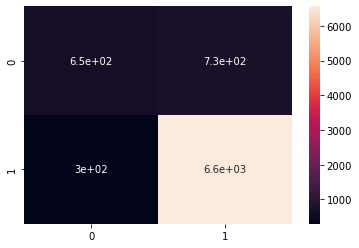

In [20]:
score_metrics(temp,test_label.to_numpy())

In [25]:
pickle.dump(gmm_model,open('gmm_model.sav','wb'))

In [26]:
np.savez('ssl_gmm_results.npz',name1 = temp,nam2 = test_label.to_numpy())